In [1]:
# !pip install scikit-learn

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
import copy

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="data/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="data/ratings_test.txt")

('data/ratings_test.txt', <http.client.HTTPMessage at 0x21f042e14f0>)

In [4]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

In [5]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [6]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수

테스트용 리뷰 개수 : 50000


In [8]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [9]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [10]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [11]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


레이블의 분포를 비슷하게 해야 한다.

<Axes: xlabel='label'>

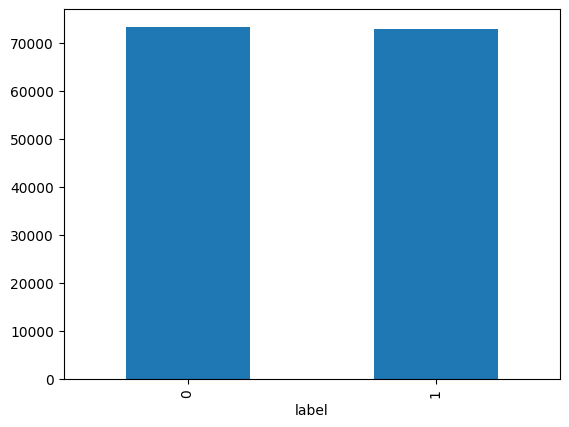

In [12]:
train_data['label'].value_counts().plot(kind = 'bar')

In [13]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [14]:
print(train_data.isnull().values.any())

True


In [15]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [16]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


fillna  
dropna

In [17]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [18]:
print(len(train_data))

146182


In [19]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [20]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [21]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'] = train_data['document'].replace('', np.nan)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [22]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [23]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [24]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'] = test_data['document'].replace('', np.nan) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [25]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [26]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [27]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [07:19<00:00, 330.70it/s]


In [28]:
X_train_test = copy.copy(X_train)
print(id(X_train))
print(id(X_train_test))

2332289729024
2332244520000


In [29]:
print(X_train_test[:3])

[['아', '더빙', '진짜', '짜증나네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'], ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천']]


In [30]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [03:50<00:00, 212.22it/s]


In [31]:
X_test_test = copy.copy(X_test)
print(id(X_test))
print(id(X_test_test))

2335511227584
2333026551360


In [32]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [33]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_val==0)/len(y_val) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_val)/len(y_val) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [34]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 88276


In [35]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])


훈련 데이터에서의 단어 영화의 등장 횟수 : 40264
훈련 데이터에서의 단어 공감의 등장 횟수 : 784


In [36]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '너무', '정말', '만', '적', '진짜', '으로', '로', '점', '에서']


In [37]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 88276
등장 빈도가 2번 이하인 희귀 단어의 수: 60078
단어 집합에서 희귀 단어의 비율: 68.05700303593277
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.644509532507002


In [38]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 28198


In [39]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size

28198

In [40]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [41]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [42]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 28200


In [43]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


In [44]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [45]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_val, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [46]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[373, 2422, 7023, 16429]
[9560, 3697, 75, 2346, 544, 24, 1, 615]


In [47]:
print(X_train[373])
print(X_train[2422])
print(X_train[7023])
print(X_train[16429])

['이자스민', '나와서', '점줌', '영화', '괜찮음']
['진짜', '최악', '영화']
['올리버', '스톤', '젠', '됐어']
['사무라이', '대작', '중', '대작', '입니다']


In [48]:
print(X_train[2415])
print(X_train[3138])
print(X_train[4])
print(X_train[2095])
print(X_train[422])
print(X_train[87])
print(X_train[5768])
print(X_train[19])
print(X_train[307])

['그런', '결말', '밉지만', '이영화', '사랑', '한다']
['달달']
['평점', '너무', '낮아', '년', '영화', '였다니', '전미선', '대단']
['이런', '사랑', '나도', '해', '봤으면', '좋겠다', '영화', '같은', '사랑']
['사람', '냄새', '나', '밴드', '이야기', '더불어', '지금', '가닥', '배우', '풋풋한', '시절', '까지', '엿볼수있는', '영화', '유쾌하지만은', '않지만', '그래도', '나름', '괜찮은', '결말', '보여준다']
['불륜', '교묘하게', '매력', '적', '으로', '포장', '해', '낸', '사탄', '영화']
['ㅋ', '요즘', '금요일', '무척', '이나', '기다려진답니다', '보고', '또', '봐도', '넘', '잼있으요', '몬스타', '화이팅']
['배우', '예쁘고', '잘생기고', '나쁘지는', '않은데', '스토리', '너무', '뻔', '해보인다']
['점', '대', '아님', 'ㅋ']


In [49]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [50]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[2]]
print('기존의 첫번째 샘플 :', X_train[2])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['주', '동안', '내내', '출생의비밀', '보면서', '일주일', '스트레스', '확', '풀렸는데', '내일', '마지막', '이라니', '특히', '제', '좋아하는', '정이현', '성유리', '누나', '못', '보게되', '다니', '하지만', '그동안', '저', '에게', '즐거움', '주신', '출생의비밀', '여러분', '께', '깊은', '감사', '드립니다']
복원된 첫번째 샘플 : ['주', '동안', '내내', '출생의비밀', '보면서', '일주일', '스트레스', '확', '<UNK>', '내일', '마지막', '이라니', '특히', '제', '좋아하는', '<UNK>', '성유리', '누나', '못', '보게되', '다니', '하지만', '그동안', '저', '에게', '즐거움', '주신', '출생의비밀', '여러분', '께', '깊은', '감사', '드립니다']


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.925228261430266


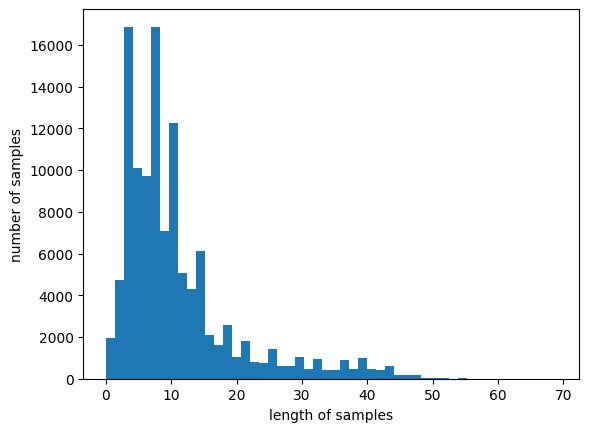

In [51]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [53]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.11850680055711


In [54]:
test_se = pd.Series(encoded_X_train)
display(test_se)

0                                  [373, 2422, 7023, 16429]
1                   [9560, 3697, 75, 2346, 544, 24, 1, 615]
2         [428, 582, 243, 19004, 256, 2893, 1733, 1557, ...
3                                                  [3, 205]
4                  [13, 3, 2600, 100, 2, 4693, 14520, 3545]
                                ...                        
116309                                         [3, 1443, 1]
116310                                      [266, 31, 1442]
116311    [35, 2342, 1492, 8026, 1077, 6852, 10725, 1314...
116312    [2217, 19366, 6570, 527, 630, 1, 2587, 1517, 8...
116313                    [809, 2633, 20, 1533, 20217, 570]
Length: 116314, dtype: object

In [55]:
features = np.zeros((len(test_se), max_len), dtype=int)
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [56]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [57]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [  373  2422  7023 16429     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [58]:
len(padded_X_train)

116314

In [59]:
len(y_train)

116314

In [60]:
len(y_val)

29079

In [61]:
len(padded_X_train) == len(y_train)

True

데이터저장

In [62]:
import numpy as np

# 데이터를 .npz 파일로 저장
np.savez('data/padded_data.npz', 
         padded_X_train=padded_X_train, 
         padded_X_valid=padded_X_valid, 
         padded_X_test=padded_X_test, 
         y_train=y_train, 
         y_valid=y_val, 
         y_test=y_test)